# Generating Synthetic Data Using GANs

In this demonstration, a Generative Adversarial Network (GAN) will be used to generate tabular synthetic data. That data will be used to train machine learning algorithms and the results will be assessed. 

## Data
A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

## Loading Packages and Data

In [1]:
# Imports the necessary packages

import os
import swat
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Creates a connection to the CAS server

conn = swat.CAS('server.demo.sas.com', 30570, 'student', 'Metadata0')

In [3]:
# Loads the necessary action sets

conn.loadactionset("aStore")
conn.loadactionset("dataPreprocess")
conn.loadactionset("dataStep")
conn.loadactionset("decisionTree")
conn.loadactionset("generativeAdversarialNet")
conn.loadactionset("percentile")
conn.loadactionset("sampling")

NOTE: Added action set 'aStore'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'dataStep'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'generativeAdversarialNet'.
NOTE: Added action set 'percentile'.
NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.00279s, user: 0.00138s, sys: 0.00138s, mem: 0.232mb

In [4]:
# Changes session timeout

mytime = 60*60*24
conn.session.timeout(time=mytime)

+ Elapsed: 0.000187s, user: 0.000174s, mem: 0.225mb

In [5]:
# Creates CASLib to load data into memory

conn.table.addCaslib(name='mycl', path='/workshop/winsas/VOSI', subDirectories = True, dataSource='PATH', activeOnAdd=True)

NOTE: 'mycl' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'mycl'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
0,mycl,PATH,,/workshop/winsas/VOSI/,,1.0,1.0,1.0,0.0,0.0,0.0,Not Specified


In [6]:
#Load CSV containing hmeq dataset and creates a CASTable object

conn.table.loadTable(caslib='mycl', path='hmeq.csv', casOut=dict(name='hmeq', replace=True))
hmeq = conn.CASTable("hmeq")

NOTE: Cloud Analytic Services made the file hmeq.csv available as table HMEQ in caslib mycl.


## Data Exploration

In [7]:
# Displays table information

hmeq.info()

CASTable('hmeq')
Data columns (total 13 columns):
            N   Miss     Type
BAD      5960  False   double
LOAN     5960  False   double
MORTDUE  5442   True   double
VALUE    5848   True   double
REASON   5708   True  varchar
JOB      5681   True  varchar
YOJ      5445   True   double
DEROG    5252   True   double
DELINQ   5380   True   double
CLAGE    5652   True   double
NINQ     5450   True   double
CLNO     5738   True   double
DEBTINC  4693   True   double
dtypes: double(11), varchar(2)
data size: 785334
vardata size: 70134
memory usage: 785456


In [8]:
# Displays a sample of the dataset

hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [9]:
# Displays the distribution of the numeric variables

hmeq.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66069.000000,3.000000,0.000000,0.000000,115.103197,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119831.500000,13.000000,0.000000,0.000000,231.574834,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [10]:
# Displays distribution of the categorical variables

hmeq.describe(include = "varchar")

,REASON,JOB
count,5708,5681
unique,2,6
top,DebtCon,Other
freq,3928.0,2388.0


In [11]:
# Displays the number of distinct values for each column

hmeq.distinct()

,Column,NDistinct,NMiss,Trunc
0,BAD,2.0,0.0,0.0
1,LOAN,540.0,0.0,0.0
2,MORTDUE,5054.0,518.0,0.0
3,VALUE,5382.0,112.0,0.0
4,REASON,3.0,252.0,0.0
5,JOB,7.0,279.0,0.0
6,YOJ,100.0,515.0,0.0
7,DEROG,12.0,708.0,0.0
8,DELINQ,15.0,580.0,0.0
9,CLAGE,5315.0,308.0,0.0


array([[<Axes: title={'center': 'BAD'}>,
        <Axes: title={'center': 'LOAN'}>,
        <Axes: title={'center': 'MORTDUE'}>],
       [<Axes: title={'center': 'VALUE'}>,
        <Axes: title={'center': 'YOJ'}>,
        <Axes: title={'center': 'DEROG'}>],
       [<Axes: title={'center': 'DELINQ'}>,
        <Axes: title={'center': 'CLAGE'}>,
        <Axes: title={'center': 'NINQ'}>],
       [<Axes: title={'center': 'CLNO'}>,
        <Axes: title={'center': 'DEBTINC'}>, <Axes: >]], dtype=object)

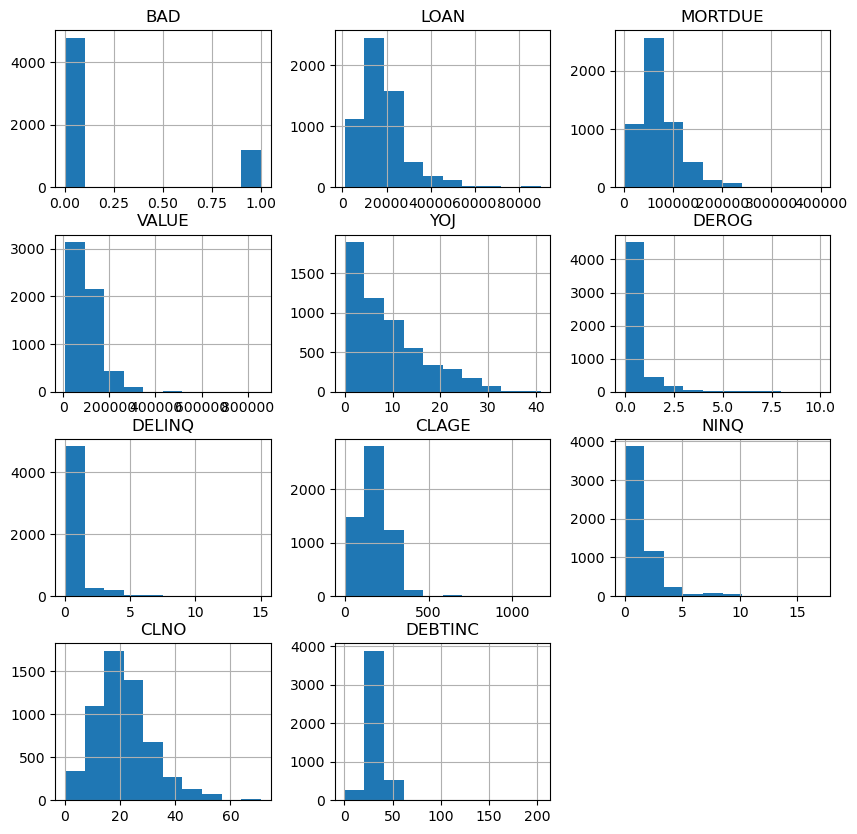

In [12]:
# Displays a histogram for all "double" type columns

hmeq.hist(figsize = (10,10))

## Missing Value Imputation

In [13]:
# Creates a list of the input variables as well as the target variable

inputs = hmeq.columns[1:]
nominals = ["BAD", "JOB", "REASON", "DEROG", "DELINQ", "NINQ"]
target = "BAD"

In [14]:
# Performs simple imputation on the continuous variables

conn.dataPreprocess.impute(
    table              = "hmeq",
    methodContinuous   = 'MEDIAN',
    methodNominal      = 'MODE',
    inputs             = inputs,
    copyAllVars        = True,
    casOut             = dict(name = "hmeq", replace = True)
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
0,BAD,Median,IMP_BAD,5960.0,0.0,0.000000,
1,LOAN,Median,IMP_LOAN,5960.0,0.0,16300.000000,
2,MORTDUE,Median,IMP_MORTDUE,5442.0,518.0,65019.000000,
3,VALUE,Median,IMP_VALUE,5848.0,112.0,89235.500000,
4,REASON,Mode,IMP_REASON,5708.0,252.0,NaN,DebtCon
5,JOB,Mode,IMP_JOB,5681.0,279.0,NaN,Other
6,YOJ,Median,IMP_YOJ,5445.0,515.0,7.000000,
7,DEROG,Median,IMP_DEROG,5252.0,708.0,0.000000,
8,DELINQ,Median,IMP_DELINQ,5380.0,580.0,0.000000,
9,CLAGE,Median,IMP_CLAGE,5652.0,308.0,173.466667,


In [15]:
# Updates the two lists such that they include imputed columns

inputs = [i for i in list(hmeq.columns[1:]) if "IMP_" in i][1:]
nominals = ["BAD", "IMP_JOB", "IMP_REASON", "IMP_DEROG", "IMP_DELINQ", "IMP_NINQ"]

array([[<Axes: title={'center': 'IMP_CLAGE'}>,
        <Axes: title={'center': 'IMP_CLNO'}>,
        <Axes: title={'center': 'IMP_DEBTINC'}>],
       [<Axes: title={'center': 'IMP_DELINQ'}>,
        <Axes: title={'center': 'IMP_DEROG'}>,
        <Axes: title={'center': 'IMP_LOAN'}>],
       [<Axes: title={'center': 'IMP_MORTDUE'}>,
        <Axes: title={'center': 'IMP_NINQ'}>,
        <Axes: title={'center': 'IMP_VALUE'}>],
       [<Axes: title={'center': 'IMP_YOJ'}>, <Axes: >, <Axes: >]],
      dtype=object)

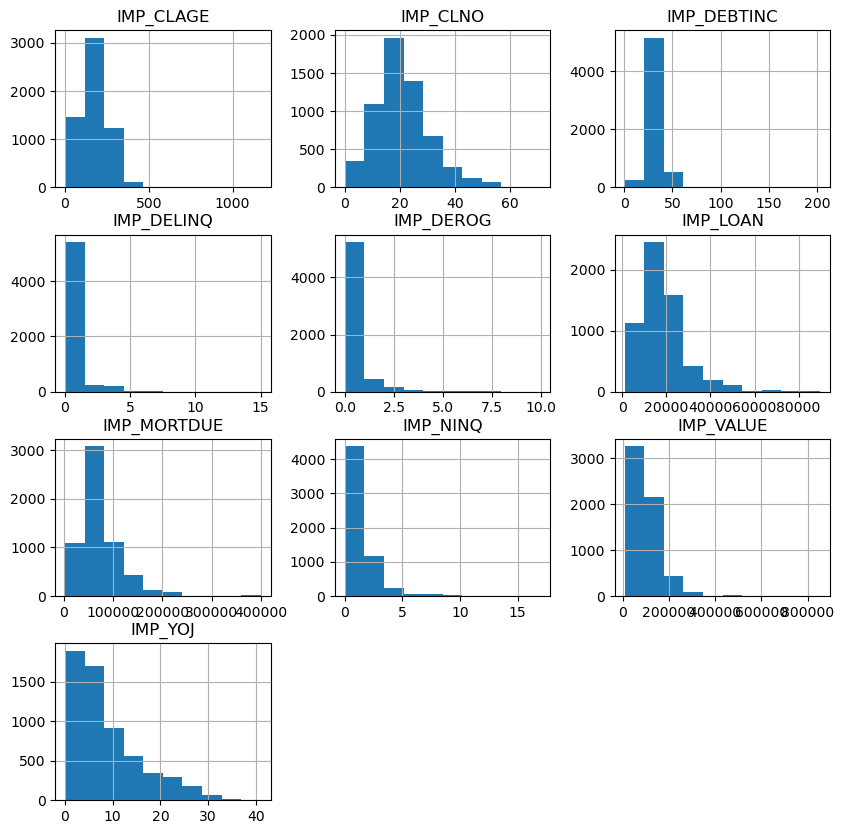

In [16]:
# Visualizes the distribution of the imputed variables 

hmeq[inputs].hist(figsize = (10,10))

## Training GAN

**NOTE:** Due to time constraints with the demonstration the GAN model will not be trained live. The model aStore can be used to generate synthetic data.

In [22]:
# Trains the GAN and generates synthetic data

tabgan_results = conn.tabularGanTrain(table = dict(name = "hmeq", vars = inputs + ["BAD"]),
                                      nominals      = nominals,
                                      gpu           = {"useGPU":True,   "device":0},
                                      gmmOptions    = {"seed": 42},
                                      optimizerAe   = {"method":'ADAM', "numEpochs":1000},
                                      optimizerGan  = {"method":'ADAM', "numEpochs":3000},
                                      miniBatchSize = 500,
                                      seed          = 42,
                                      scoreSeed     = 8,
                                      numSamples    = 15000,
                                      saveState     = {"name":"cpctStore",  "replace":True},
                                      casOut        = {"name":"synth_data", "replace":True}
                                      )

NOTE: Using SEED=42.
NOTE: The maximum number of clusters is set as 100.
NOTE: The Dirichlet process mass is set as 1.
NOTE: GMM is using the Variational Bayesian for model inference.
NOTE: The VB threshold is set as 0.01.
NOTE: The maximum number of VB iterations is set as 100.
NOTE: Beginning data reading and levelization.
NOTE: Data reading complete.
NOTE: VB iteration 0.
NOTE: VB iteration 1.
NOTE: VB iteration 2.
NOTE: VB iteration 3.
NOTE: VB iteration 4.
NOTE: VB iteration 5.
NOTE: VB iteration 6.
NOTE: VB iteration 7.
NOTE: VB iteration 8.
NOTE: VB iteration 9.
NOTE: VB iteration 10.
NOTE: VB iteration 11.
NOTE: VB iteration 12.
NOTE: VB iteration 13.
NOTE: VB iteration 14.
NOTE: VB iteration 15.
NOTE: VB iteration 16.
NOTE: VB iteration 17.
NOTE: VB iteration 18.
NOTE: VB iteration 19.
NOTE: VB iteration 20.
NOTE: VB iteration 21.
NOTE: VB iteration 22.
NOTE: VB iteration 23.
NOTE: VB iteration 24.
NOTE: VB iteration 25.
NOTE: VB iteration 26.
NOTE: VB iteration 27.
NOTE: VB i

In [23]:
# Stores the loss results of the tab GAN

loss_df = tabgan_results["IterHistory"]
autoencoder_loss = loss_df.iloc[0:1000, 0:2]
gan_loss = loss_df.iloc[1000: , [0, 2, 3]]

In [24]:
# Displays a sample of the gan loss dataframe

gan_loss.head()

,EpochNumber,GeneratorLoss,DiscriminatorLoss
1000,1,1.512195,-0.015838
1001,2,1.576480,-0.000094
1002,3,1.515081,0.014173
1003,4,1.556356,0.006487
1004,5,1.580319,0.005726


Text(0.5, 1.0, 'Autoencoder Loss vs. Epochs')

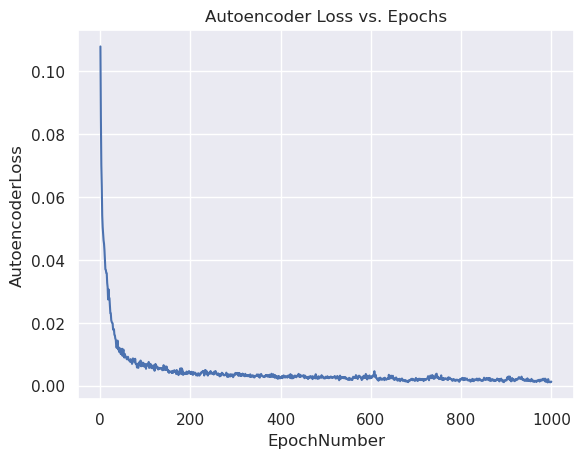

In [25]:
# Plots the loss for the autoencoder

sns.lineplot(data = autoencoder_loss, x = "EpochNumber", y = "AutoencoderLoss").set_title("Autoencoder Loss vs. Epochs")

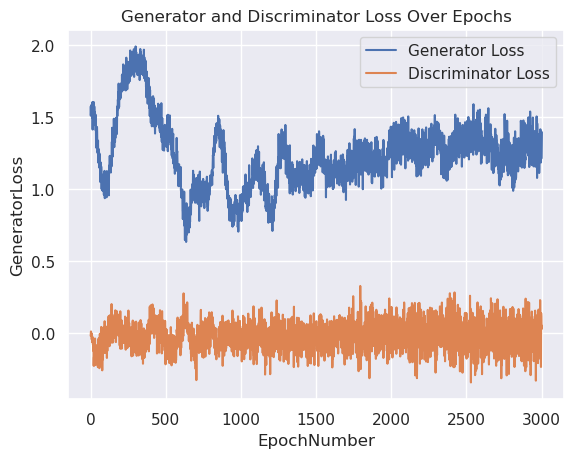

In [26]:
# Plots the generator vs. disciminator loss

sns.set_theme()
gan_loss_plot = sns.lineplot(data = gan_loss, x = "EpochNumber", y = "GeneratorLoss", label = "Generator Loss")
gan_loss_plot = sns.lineplot(data = gan_loss, x = "EpochNumber", y = "DiscriminatorLoss", label = "Discriminator Loss")
gan_loss_plot.set_title("Generator and Discriminator Loss Over Epochs")
plt.legend()
plt.show()

In [27]:
# # Saves the synthetic dataset 

conn.table.save(table = "synth_data", caslib = "mycl", name = "synth_hmeq")

# Loads the synthetic dataset

conn.table.loadtable(path = "synth_hmeq.sashdat", caslib = "mycl", casout = dict(name = "synth_data", replace = True))

NOTE: Cloud Analytic Services made the file synth_hmeq.sashdat available as table SYNTH_DATA in caslib mycl.


ERROR: The SASHDAT file /workshop/winsas/VOSI/synth_hmeq.sashdat already exists. Specify the replace option to overwrite an existing file.
ERROR: The action stopped due to errors.


[caslib]

 'mycl'

[tableName]

 'SYNTH_DATA'

[casTable]

 CASTable('SYNTH_DATA', caslib='mycl')

+ Elapsed: 0.00136s, user: 0.00127s, sys: 6e-06s, mem: 0.723mb

## Generating Data with GAN

Once a model has been trained, we don't need to train it again to generate new data. An aStore file can be used to generate new data using a model that's been trained before. 

The code cells below illustrate how this process looks.

In [ ]:
# # Loads the trained GAN aStore into memory

# conn.table.loadtable(caslib = "mycl", path = "hmeq_gan.sashdat", casOut = dict(name = "cpctStore", replace = True))

In [ ]:
# # Uses the aStore file to create new synthetic data

# conn.aStore.score(table  = dict(name = "hmeq", vars = inputs + ["BAD"]),
#                   out    = "synth_data",
#                   rstore = "cpctStore")

## Synthetic Data Exploration

In [ ]:
# Displays the newly generated synthetic data

synth_data = conn.CASTable("synth_data")
synth_data.head()

In [ ]:
# Displays information for the newly generated synthetic dataset

synth_data.info()

In [ ]:
# Computes the summary statistics for the original and synthetic datasets

hmeq_stats = hmeq[inputs].describe()
synth_stats = synth_data.describe()

# Displays the summary statistics of the synthetic data

synth_stats

In [ ]:
# Computes the difference in summary statistics between the real and synthetic data respectively

columns = hmeq_stats.columns.to_list()
sum_stat_comp = pd.DataFrame()

for i in columns:
    sum_stat_comp[i] = hmeq_stats[i] - synth_stats[i]
    
sum_stat_comp

In [ ]:
# Displays the distribution of the original dataset

hmeq[inputs].hist(figsize = (10, 10))

In [ ]:
# Displays the distribution of the synthetic data

synth_data[inputs].hist(figsize = (10, 10))

## Synthetic Data Transformation

Below we apply some changes to the synthetic data to respect the lower limits of some of the variables in the dataset.

In [ ]:
# Replaces negative values with 0

conn.dataStep.runCode(code = """
                              data mycl.synth_data;
                                  set mycl.synth_data; 
                                  if imp_clage < 0 then imp_clage = 0;
                                  if imp_clno < 0 then imp_clno = 0;
                                  if imp_debtinc < 0 then imp_debtinc = 0;
                                  if imp_loan < 0 then imp_loan = 0;
                                  if imp_mortdue < 0 then imp_mortdue = 0;
                                  if imp_value < 0 then imp_value = 0;
                                  if imp_yoj < 0 then imp_yoj = 0;
                              run;
                              """)

In [ ]:
# Displays the distribution of the target variable in the real data

hmeq["BAD"].value_counts()

In [ ]:
# Displays the distribution of the target variable in the synthetic dataset

synth_data["BAD"].value_counts()

## Data Partitioning

In [ ]:
# Partitions the real dataset

conn.sampling.stratified(table = "hmeq",
                         target = "BAD",
                         samppct = 70,
                         seed = 42,
                         partind = True,
                         output = dict(casout = dict(name = "hmeq", replace = True), copyVars = "ALL", partindname = "_PartInd_")
                         )

In [ ]:
# Displays the target column distribution percentage 

display(hmeq.groupby("_PartInd_1")["BAD"].value_counts())
hmeq.groupby("_PartInd_1")["BAD"].value_counts(normalize = True)

In [ ]:
# Computes the proportion of events that need to be selected to get a synthetic dataset of the same dimension

evt_cnt = synth_data["BAD"].value_counts()[1]
evt_pct = (1189*0.7*100)/evt_cnt

In [ ]:
# Partitions the synthetic dataset so that the distribution matches the distribution of the real dataset

conn.sampling.oversample(table = dict(name = "synth_data", groupBy = "BAD"),
                         event = "1",
                         eventProp = 0.199,
                         samppctevt = evt_pct,
                         seed = 42,
                         output = dict(casout = dict(name = "synth_data_train", replace = True), copyVars = "ALL")
                         )

In [ ]:
# Displays the target distribution of the synthetic dataset that will be used to train the model

synth_train = conn.CASTable("synth_data_train")
synth_train["BAD"].value_counts()

## Training Gradient Boosting Models

A Gradient Boosting model will be trained using the real dataset and another using the synthetic dataset. Both models will be assessed using the real validation partition.

In [ ]:
# Creates a list of the datasets that will be used to create the models

datasets = ["hmeq", "synth_data_train"]

In [ ]:
# Trains gradient boosting models using the original and synthetic datasets

for data in datasets:
    
    model_name = "gboost_" + data
    
    if data == "hmeq":
        table = dict(name = data, where = "_PartInd_1")
    else:
        table = dict(name = data)
    
    conn.decisionTree.gbtreeTrain(
        table    = table,
        target   = target, 
        inputs   = inputs, 
        nominals = nominals,
        m        = 8,
        nBins    = 100,
        nTree    = 100,
        casOut   = dict(name = model_name, replace = True) 
    )

## Scoring with Gradient Boosting Models

In [ ]:
# Scores using both of the gradient boosting models

for data in datasets:
    
    model_name = "gboost_" + data
    output_tbl = "scored_" + data
    assess_tbl = "assessed_" + data
    
    conn.decisionTree.gbtreeScore(
        table    = dict(name = "hmeq", where = '_PartInd_1 = 0'),
        model = model_name,
        casout = dict(name=output_tbl,replace=True),
        copyVars = target,
        encodename = True,
        assessonerow = True
    )
    
    conn.percentile.assess(
       table = output_tbl,
       inputs = "P_BAD1",
       casout = dict(name=assess_tbl,replace=True),
       response = target,
       event = "1"
    )

## Assessing Model's Performance

In [ ]:
# Creates references to the in memory tables, downloads them, and creates a new column

train_results = conn.CASTable("assessed_hmeq_roc")
synth_results = conn.CASTable("assessed_synth_data_train_roc")

train_results = train_results.to_frame()
synth_results = synth_results.to_frame()

train_results["Model"] = "real_data_gboost"
synth_results["Model"] = "synth_data_gboost"

In [ ]:
# Displays summary statistics for the Gboost models trained on real and synthetic data

df_assess = pd.DataFrame()
df_assess = pd.concat([train_results, synth_results])
df_assess.reset_index(drop = True, inplace = True)

compare = df_assess.iloc[[20, 120], :]
compare[["Model", "_ACC_", "_Sensitivity_", "_Specificity_", "_F1_"]]

## Combining Real and Synthetic Data

Augments the real dataset by combining it with synthetic positive insta.

In [ ]:
# Creates a copy of the synthetic data

conn.table.copytable(table = dict(name = "synth_data", where = "BAD = 1"), casout = dict(name = "new_synth", replace = True))
new_synth = conn.CASTable("new_synth")

In [ ]:
# Creates a new training and validation dataset using the partition indicator

conn.table.copyTable(table = dict(name = "hmeq", where = "_PartInd_1 = 1"), casout = dict(name = "train", replace = True))
conn.table.copyTable(table = dict(name = "hmeq", where = "_PartInd_1 = 0"), casout = dict(name = "valid", replace = True))

In [ ]:
# Creates a training and validation CASTable object

train = conn.CASTable("train")
valid = conn.CASTable("valid")

In [ ]:
# Modifies the three tables so that the structures match

conn.table.altertable(name = train, keep = inputs + ["BAD"])
conn.table.altertable(name = valid, keep = inputs + ["BAD"])
conn.table.altertable(name = new_synth, keep = inputs + ["BAD"])

In [ ]:
# Appends the training dataset with the synthetic dataset

conn.table.append(source = dict(name = "train"), target = dict(name = "new_synth"))

In [ ]:
# Displays the shape of the combined dataset

new_synth.shape

In [ ]:
# Displays the target distribution

new_synth["BAD"].value_counts(normalize = True)

## Training Gradient Boosting Model with Augmented Dataset

In [ ]:
# Trains a gradient boosting model using the augmented dataset

conn.decisionTree.gbtreeTrain(table    = new_synth,
                              target   = target, 
                              inputs   = inputs, 
                              nominals = nominals,
                              m        = 8,
                              nBins    = 100,
                              nTree    = 100,
                              casOut   = dict(name = "gboost_aug_data", replace = True)
                             )

## Scoring with New Gradient Boosting Model

In [ ]:
# Scores using the gradient boosting model

conn.decisionTree.gbtreeScore(table        = valid,
                              model        = "gboost_aug_data",
                              casout       = dict(name="scored_gboost_aug_data",replace=True),
                              copyVars     = target,
                              encodename   = True,
                              assessonerow = True
                              )

# Assesses the gradient boosting model's predictions.

conn.percentile.assess(table    = "scored_gboost_aug_data",
                       inputs   = "P_BAD1",
                       casout   = dict(name="assessed_gboost_aug_data",replace=True),
                       response = target,
                       event    = "1"
                       )

In [ ]:
# Creates a reference to the in memory table, downloads it, and creates a new column

aug_results = conn.CASTable("assessed_gboost_aug_data_ROC")
aug_results = aug_results.to_frame()
aug_results["Model"] = "aug_data_gboost"

In [ ]:
train_results["_KS2_"].idxmax()

In [ ]:
train_results.iloc[14, :]

In [ ]:
# Displays some summary statistics for the Gboost models trained on real and synthetic data

df_assess = pd.concat([train_results, synth_results, aug_results])
df_assess.reset_index(drop = True, inplace = True)
df_assess['Misclassification'] = 1-df_assess['_ACC_']
compare = df_assess.iloc[[20, 120, 220], :]
compare[["Model", "_ACC_", "_Sensitivity_", "_Specificity_", "_KS2_", "_F1_", "Misclassification", "_Cutoff_"]]

In [ ]:
# Ends the session

conn.session.endsession()